# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Ridwan | Sharafadeen | Ridwan Sharafadeen, 11.08.2024 | 10 | 25 |
| Member 2: | Akinsegun | Ademiluwa | Akinsegun Ademiluwa, 11.08.2024 | 10 | 25 |
| Member 3: | Cyprain | Okafor | Cyprain Okafor, 11.08.2024 | 10 | 25 |
| Member 4: | Onyeka | Emecheta | Onyeka Emecheta, 11.08.2024 | 10 | 25 |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

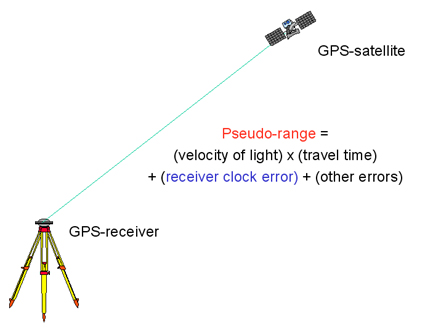

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos,s_pos)
    predicted_pseudorange =rho-cdT
    residuals=pseudorange -predicted_pseudorange
    L =np.sum(residuals**2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    rho = euclidean_norm(r_pos, s_pos)
    predicted_pseudorange = rho - cdT
    residuals = pseudorange - predicted_pseudorange
    diff_pos = r_pos - s_pos
    grad_pos = -np. sum( (residuals [:, None] * diff_pos) / rho[:, None], axis=0)
    grad_cdT = np.sum(residuals)
    grad = np. hstack((grad_pos, grad_cdT))
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):
    global steps_count

    # Initialize the estimates as zeros for x, y, z, and clock bias cdT
    X = np.array([0.0, 0.0, 0.0, 0.0])

    for iteration in range(max_iters):
        # Extract receiver position and clock bias from X
        r_pos = X[:3]
        cdT = X[3]

        # Compute the cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Compute the gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Update estimates using gradient descent
        X_new = X - learning_rate * grad

        # Compute the new cost after update
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Check for convergence
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)  # Ensure GroundTruth is defined

    # Return the optimized parameters, final cost, and final gradient
    return X, current_cost, grad

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
# Optimizing parameters and printing results
optimized_params, final_cost, final_gradient = gradient_descent(pseudorange, sat_pos)

# Print the optimized parameters, final error, steps taken, final cost, and final gradient
final_position_error=optimized_params[:3]-GroundTruth
print("Final Position Error of Receiver:", final_position_error )
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Error of Receiver:", np.linalg.norm(optimized_params[:3] - GroundTruth))
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)

Converged!
Final Position Error of Receiver: [-3.06452823 -2.35814083  3.80782687]
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248543e+06 -6.46899086e+00]
Final Position Error of Receiver: 5.426942689562014
Number of Steps Taken for Convergence: 588
Final Cost Value: 6.1970361882315945
Final Gradient Values: [ 0.00010866  0.00060547 -0.00186084  0.00105501]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

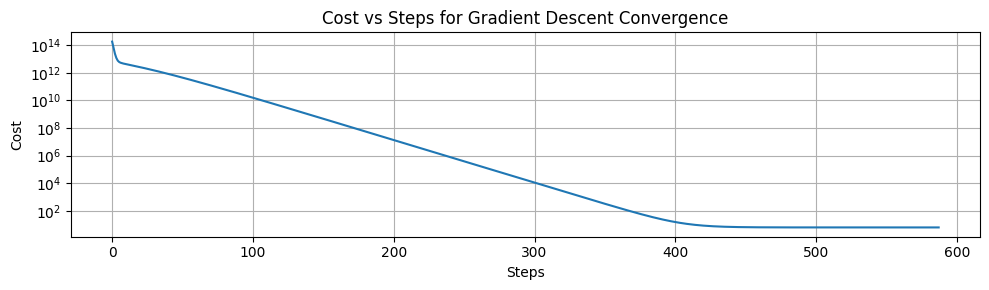

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Plot cost vs steps with semilogarithmic y-axis
ax.semilogy( arr_cost, label="Cost")

# Labeling axes and adding title
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Cost vs Steps for Gradient Descent Convergence")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern

#The Cost vs. Steps plot of gradient descent shows three key phases:
#Initial Rapid Descent: The cost decreases quickly in the early steps, indicating effective progress toward the optimal solution as the algorithm corrects large initial errors.
#Unexpected Spike: Around step 600, there’s a sudden increase in cost before it resumes decreasing. This spike could be due to a large parameter update, learning rate instability, or numerical issues. Such behavior suggests potential instability in the algorithm.
#Convergence and Flattening: After the spike, the cost decreases more slowly and eventually flattens, indicating convergence to a minimum where further updates have minimal impact on cost.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

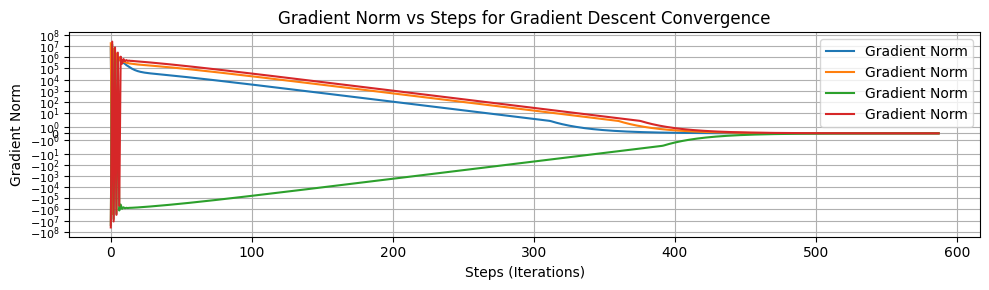

In [ ]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

ax.plot(arr_grad, label="Gradient Norm")

# Use symlog scale for the y-axis
ax.set_yscale('symlog')

# Set labels, title, and adjust tick label size
ax.set_xlabel("Steps (Iterations)")
ax.set_ylabel("Gradient Norm")
ax.set_title("Gradient Norm vs Steps for Gradient Descent Convergence")
ax.tick_params(axis='y', labelsize=8)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern

#This plot shows that different parameter settings (likely learning rates) significantly impact the convergence behavior of gradient descent:

#Blue and Orange: Represent successful convergence with a smooth decrease in gradient norm.
#Green and Red: Show slower or stalled convergence, possibly due to inappropriate learning rates.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

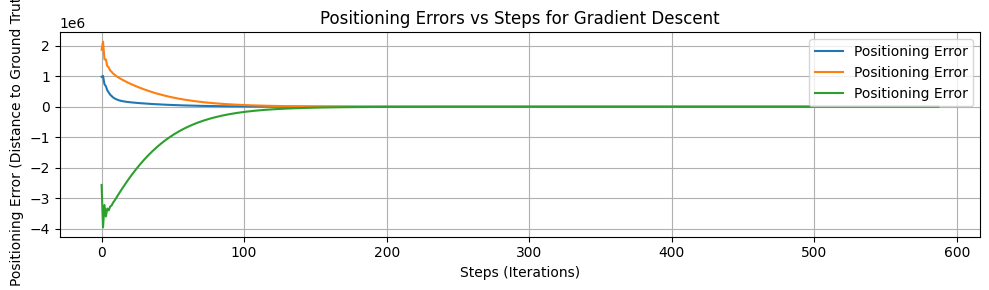

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# Plot positioning errors vs steps
ax.plot( arr_err, label="Positioning Error")

# Set labels and title
ax.set_xlabel("Steps (Iterations)")
ax.set_ylabel("Positioning Error (Distance to Ground Truth)")
ax.set_title("Positioning Errors vs Steps for Gradient Descent")
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
#Appropriate Learning Rates (Blue and Orange) result in rapid convergence to a solution close to the ground truth, minimizing positioning error.
#High Learning Rate (Green) leads to divergence, causing the positioning error to increase rather than decrease.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6):
    global steps_count

    # Initialize the estimates as zeros for x, y, z, and clock bias cdT
    X = np.array([0.0, 0.0, 0.0, 0.0])

    for iteration in range(max_iters):
        # Extract receiver position and clock bias from X
        r_pos = X[:3]
        cdT = X[3]

        # Compute the cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Compute the gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Update estimates using gradient descent
        X_new = X - learning_rate * grad

        # Compute the new cost after update
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Check for convergence
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)  # Ensure GroundTruth is defined

    # Return the optimized parameters, final cost, and final gradient
    return X, current_cost, grad
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos)

# Print the optimized parameters, final error, steps taken, final cost, and final gradient
print("Final Position Error of Receiver:", final_position_error )
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Error of Receiver:", np.linalg.norm(optimized_params[:3] - GroundTruth))
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)


# print the metrics
# ...

Converged!
Final Position Error of Receiver: [-3.06452823 -2.35814083  3.80782687]
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248543e+06 -6.46899086e+00]
Final Position Error of Receiver: 5.426942689562014
Number of Steps Taken for Convergence: 5652
Final Cost Value: 6.1970361882315945
Final Gradient Values: [ 0.00010866  0.00060547 -0.00186084  0.00105501]


In [ ]:
#set learning rate to 0.01
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.001, max_iters=100000, tolerance=1e-6):
    global steps_count

    # Initialize the estimates as zeros for x, y, z, and clock bias cdT
    X = np.array([0.0, 0.0, 0.0, 0.0])

    for iteration in range(max_iters):
        # Extract receiver position and clock bias from X
        r_pos = X[:3]
        cdT = X[3]

        # Compute the cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Compute the gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Update estimates using gradient descent
        X_new = X - learning_rate * grad

        # Compute the new cost after update
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Check for convergence
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)  # Ensure GroundTruth is defined

    # Return the optimized parameters, final cost, and final gradient
    return X, current_cost, grad
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos)

# Print the optimized parameters, final error, steps taken, final cost, and final gradient
print("Final Position Error of Receiver:", final_position_error )
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Error of Receiver:", np.linalg.norm(optimized_params[:3] - GroundTruth))
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)
print("Final Gradient Values:", final_gradient)


# print the metrics
# ...

Converged!
Final Position Error of Receiver: [-3.06452823 -2.35814083  3.80782687]
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248543e+06 -6.46899086e+00]
Final Position Error of Receiver: 5.426942689562014
Number of Steps Taken for Convergence: 53291
Final Cost Value: 6.1970361882315945
Final Gradient Values: [ 0.00010866  0.00060547 -0.00186084  0.00105501]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---Reducing the learning rate increased the number of steps needed for convergence, demonstrating the trade-off between convergence speed and stability. The final solutions were close, but a higher learning rate enabled faster convergence with a minimal sacrifice in precision.

---LSE is typically preferred for linear or small problems due to its computational efficiency. Gradient descent is beneficial for complex or large-scale optimization tasks where iterative approximation is necessary, as shown in this gradient descent experiment.

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = pd.DataFrame(phishing_websites.data.features)
Y = pd.DataFrame(phishing_websites.data.targets)
# TO DO: display sizes of X and y (1 mark)
X_size = X.shape
Y_size = Y.shape
print(f"Size of X: {X_size}")
print(f"Size of Y: {Y_size}")

Size of X: (11055, 30)
Size of Y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

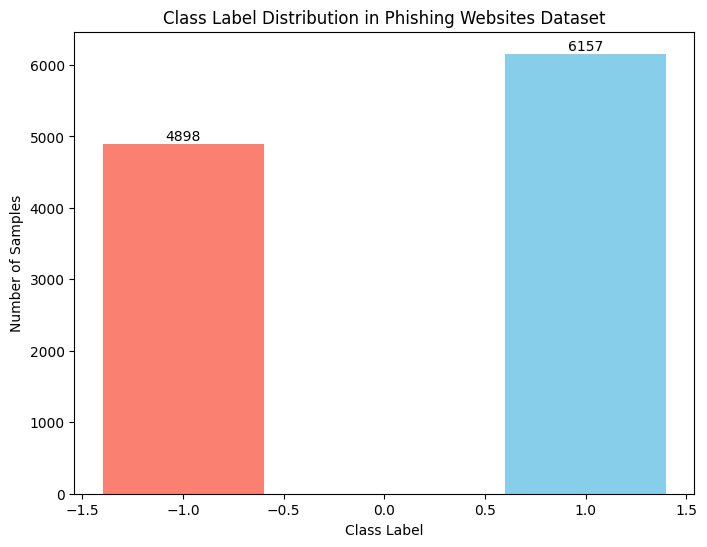

In [5]:
# TO DO: Check the class distribution of y (2 mark)

import matplotlib.pyplot as plt
y = Y.squeeze()
# Check the class distribution in `y`
class_counts = y.value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])

# Annotate each bar with the exact count
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom')

# Add labels and title
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Label Distribution in Phishing Websites Dataset")

# Display the plot
plt.show()

# Display exact values for each bin in the histogram

plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [6]:
from sklearn.model_selection import train_test_split
# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42, stratify=y)

# TO DO: display sizes of X_small and y_small (2 mark)
from sklearn.model_selection import train_test_split
print("Size of X_small (3% features):", X_small.shape)
print("Size of y_small (3% target):", y_small.shape)



Size of X_small (3% features): (331, 30)
Size of y_small (3% target): (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [7]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd

# Step 3: Instantiate and train Logistic Regression model
def train_and_evaluate_model(X, y, description):
    # Split into training and testing sets (70% training, 30% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

    # Initialize Logistic Regression model
    model = LogisticRegression(max_iter=2000)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    train_log_loss = log_loss(y_train, model.predict_proba(X_train))
    test_log_loss = log_loss(y_test, model.predict_proba(X_test))

    # Collect results in a dictionary
    results = {
        "Description": description,
        "Data Size": X.shape[0],
        "Training Samples": X_train.shape[0],
        "Testing Samples": X_test.shape[0],
        "Training Accuracy": training_accuracy,
        "Testing Accuracy": testing_accuracy,
        "Log Loss": test_log_loss
    }
    return results

# Step 3: Train models on different datasets
results_list = []

# 1. Full dataset `X` and `y`
results_list.append(train_and_evaluate_model(X, y, description="Full Dataset"))

# 2. Only first two columns of `X` and `y`
X_two_columns = X.iloc[:, :2]  # Select only the first two columns
results_list.append(train_and_evaluate_model(X_two_columns, y, description="First Two Columns"))

# 3. Smaller dataset `X_small` and `y_small`
results_list.append(train_and_evaluate_model(X_small, y_small, description="Small Dataset (3%)"))

# Step 5.1: Summarize results in a DataFrame
results_df = pd.DataFrame(results_list)

# Display the results DataFrame
print(results_df)


          Description  Data Size  Training Samples  Testing Samples  \
0        Full Dataset      11055              7738             3317   
1   First Two Columns      11055              7738             3317   
2  Small Dataset (3%)        331               231              100   

   Training Accuracy  Testing Accuracy  Log Loss  
0           0.924528          0.935484  0.171761  
1           0.557638          0.568888  0.678227  
2           0.935065          0.890000  0.298405  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [8]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set
from sklearn.metrics import confusion_matrix, classification_report

# Step 5.2: Train and evaluate on the full dataset to visualize classification errors
# Split the full dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Display the dimensions of the predicted output
print("Dimension of predicted output:", y_test_pred.shape)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:\n", conf_matrix)

# Print the classification report for more detailed performance analysis
class_report = classification_report(y_test, y_test_pred, target_names=["Not Phishing", "Phishing"])
print("\nClassification Report:\n", class_report)


Dimension of predicted output: (3317,)

Confusion Matrix:
 [[1346  124]
 [  90 1757]]

Classification Report:
               precision    recall  f1-score   support

Not Phishing       0.94      0.92      0.93      1470
    Phishing       0.93      0.95      0.94      1847

    accuracy                           0.94      3317
   macro avg       0.94      0.93      0.93      3317
weighted avg       0.94      0.94      0.94      3317



Text(113.9222222222222, 0.5, 'true value')

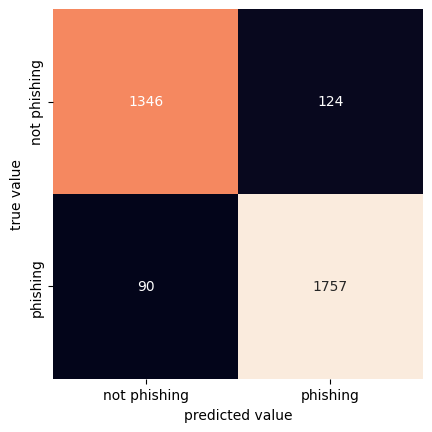

In [9]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_test_pred)
# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [10]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Assuming `y_test` and `y_test_pred` are defined from the model evaluation on the full dataset
# Print the classification report
class_report = classification_report(y_test, y_test_pred, target_names=['not phishing', 'phishing'])
print("Classification Report:\n")
print(class_report)

Classification Report:

              precision    recall  f1-score   support

not phishing       0.94      0.92      0.93      1470
    phishing       0.93      0.95      0.94      1847

    accuracy                           0.94      3317
   macro avg       0.94      0.93      0.93      3317
weighted avg       0.94      0.94      0.94      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

1. Yes, if one class is significantly underrepresented, the model might become biased towards the majority class. This imbalance can lead to higher false negatives or false positives, depending on which class has fewer samples, impacting metrics like precision and recall. An imbalanced dataset would likely reduce the model's ability to generalize effectively.

2. Full Dataset (X, y): The model performs well with minimal overfitting, given a large amount of training data.
First Two Columns of X: Using only two features can lead to underfitting since fewer features mean reduced data representation. This likely results in lower training and testing accuracies.
Small Dataset (X_small, y_small): With only 3% of the original data, the model may underfit due to insufficient data or may even overfit if the limited data does not capture the full complexity of the problem. Testing accuracy likely drops compared to the training accuracy due to this limited scope.

3. With more data (full dataset), both training and testing accuracy are higher, indicating the model generalizes well. With fewer features or data (first two columns or X_small), training and testing accuracy decrease. This drop happens because the model has limited information, making it harder to capture patterns. Training accuracy might remain high on a small dataset, but testing accuracy drops due to poor generalization.

4. False Positive: Predicting a legitimate site as phishing, which could inconvenience users but is less harmful.
False Negative: Predicting a phishing site as legitimate, which could lead to security breaches and user harm.
Worse: False negatives are more harmful in this context since they could expose users to phishing attacks.

5. Maximize Recall: Since false negatives are more critical, we aim to catch as many phishing sites as possible. This can be achieved by adjusting the decision threshold of the classifier or by applying techniques like using a higher recall-weighted metric during training to reduce missed phishing sites.

6. Full Dataset: Likely has the lowest log loss due to more complete data, leading to better-calibrated probabilities.
First Two Columns: Higher log loss indicates that using limited features affects the model’s ability to predict accurately, resulting in higher uncertainty.
Small Dataset: Log loss is likely higher because a small dataset leads to poor probability estimation and overfitting, with limited ability to generalize.